## Tokenize

In [528]:
import re
import numpy as np

def tokenize(text):
  pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
  return pattern.findall(text.lower())

## Mapping

In [529]:
def mapping(text_array):

  idx_to_word = {}
  word_to_idx = {}

  i=0; j=0
  for idx, word in enumerate(text_array):
    if word not in idx_to_word.values():
      idx_to_word[i] = word
      i+=1
      
    
    if word not in word_to_idx.keys():
      word_to_idx[word] = j
      j+=1
      

  return idx_to_word, word_to_idx

## OHE

In [530]:
def one_hot_encoding(text_array, word_to_idx, window_size):

  matrix = []

  for idx, word in enumerate(text_array):
    
    center_vec = [0 for w in word_to_idx]
    center_vec[word_to_idx[word]] = 1

    context_vec = []
    for i in range(-window_size, window_size+1):
      
      if i == 0 or idx+i < 0 or idx+i >= len(text_array) or word == text_array[idx+i]:
        continue
      
      temp = [0 for w in word_to_idx]
      temp[word_to_idx[text_array[idx+i]]] = 1 

      context_vec.append(temp)
      
    matrix.append([center_vec, context_vec])
    

  return matrix

In [531]:
text = 'Hello my name Is Samir Hello'
tokens = tokenize(text)
idxs, words = mapping(tokens)
mat = one_hot_encoding(tokens, words, window_size=2)

words, tokens ,mat

({'hello': 0, 'my': 1, 'name': 2, 'is': 3, 'samir': 4},
 ['hello', 'my', 'name', 'is', 'samir', 'hello'],
 [[[1, 0, 0, 0, 0], [[0, 1, 0, 0, 0], [0, 0, 1, 0, 0]]],
  [[0, 1, 0, 0, 0], [[1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0]]],
  [[0, 0, 1, 0, 0],
   [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]],
  [[0, 0, 0, 1, 0],
   [[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0]]],
  [[0, 0, 0, 0, 1], [[0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0]]],
  [[1, 0, 0, 0, 0], [[0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]]])

## Softmax
<img src="./images/1702141708293.png">
<img src="./images/1702141667442.png">

In [532]:
def softmax(u):
  return [np.exp(u_j) / np.sum(np.exp(u)) for u_j in u]

## Forward pass
<img src="./images/1702141784119.png">

In [533]:
def forward_pass(wt, w1, w2):

  wt = np.array(wt)

  h = np.dot(wt.T, w1)

  u = np.dot(h, w2)
  
  return softmax(u), h, u

## Loss
<img src="./images/1702145131809.png">


In [534]:
def loss(w_c, u):
  return -np.sum([u[word.index(1)] for word in w_c]) + len(w_c) * np.log(np.sum(np.exp(u)))

## Error
<img src="./images/1702145162605.png">
<img src="./images/1702145168639.png">
<img src="./images/1702145175905.png">

In [535]:
def error(out, w_c):
  out = np.array(out) 
  w_c = np.array(w_c)

  return np.sum([np.subtract(out, w) for w in w_c], axis=0)

## Backpropagation

In [536]:
def backprop(out, word, w1, w2, h):
  err = error(out, word[1]).T

  dw2 = np.outer(err, h)
  EH = np.dot(err, w2.T)
  dw1 = np.outer(EH, np.array(word[0]).T)

  return dw1.T, dw2.T

<img src="./images/1702145244596.png">
<img src="./images/1702145254830.png">

In [537]:
def learning(w1, w2, dw1, dw2, lr):
  w1 = np.subtract(w1, np.multiply(lr, dw1))
  w2 = np.subtract(w2, np.multiply(lr, dw2))

  return w1, w2


## Train

In [538]:
def train(words, vocab, lr, epochs, dim):

  w1 = np.random.uniform(-1, 1, (len(vocab), dim)) * 0.01
  w2 = np.random.uniform(-1, 1, (dim, len(vocab))) * 0.01

  history = {}
  for e in range(epochs):

    l = 0

    for word in words:
      out, h, u = forward_pass(word[0], w1, w2)
      dw1, dw2 = backprop(out, word, w1, w2, h)
      w1, w2 = learning(w1, w2, dw1, dw2, lr)

      l += loss(word[1], u)
    
    if e % 100 == 0:
      history[e] = l
  
  return w1, w2, history

## Predict

In [539]:
def predict(word, w1, w2, matrix, words, indices):
  word = word.lower()
  out, _, _ = forward_pass(matrix[words[word]][0], w1, w2)

  most_likely_idxs = np.array(out).argsort()[-4:][::-1]
  return [indices[w] for w in most_likely_idxs]

In [540]:
text1 = 'I like reading The Witcher books every night'
text = """
The future king is the prince
Daughter is the princess
Son is the prince
Only a man can be a king
Only a woman can be a queen
The princess will be a queen
The prince is a strong man
The princess is a beautiful woman
Prince is only a boy now
Prince will be king
A boy will be a man
"""
tokens = tokenize(text)
idxs, words = mapping(tokens)
mat = one_hot_encoding(tokens, words, window_size=2)

w1, w2, history = train(mat, words, lr=0.01, epochs=1000, dim=2)

In [544]:
predict('woman', w1, w2, mat, words, idxs)


['the', 'is', 'prince', 'a']

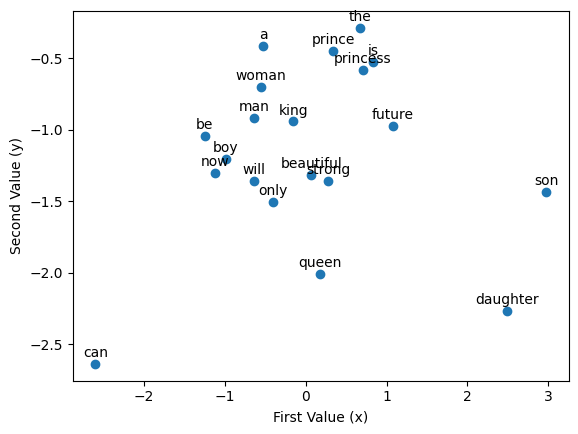

In [543]:
x_values = [point[0] for point in w1]
y_values = [point[1] for point in w1]

# Create scatter plot
plt.scatter(x_values, y_values)

# Add labels based on the dictionary
for word, idx in words.items():
    plt.annotate(word, (x_values[idx], y_values[idx]), textcoords="offset points", xytext=(0, 5), ha='center')

# Add axis labels
plt.xlabel('First Value (x)')
plt.ylabel('Second Value (y)')

# Show the plot
plt.show()